# Unit 7 Code: Nonparametric Regression and Generalized Additive Models

The goal of this assignment is to work with nonparametric regression models in R.

## Problem #1

#### (a) Simulate $n = 150$ ($x,y)$ pairs in the following way: let $x$ be random uniform numbers between zero and $\pi/2$.  Let $y_i = \sin(\pi x_i) + \varepsilon_i, \,\,\, \varepsilon_i \sim N(0, 0.5^2)$.  Plot $y$ as a function of $x$. Would a linear parametric model do well in explanation/prediction for this dataset? 

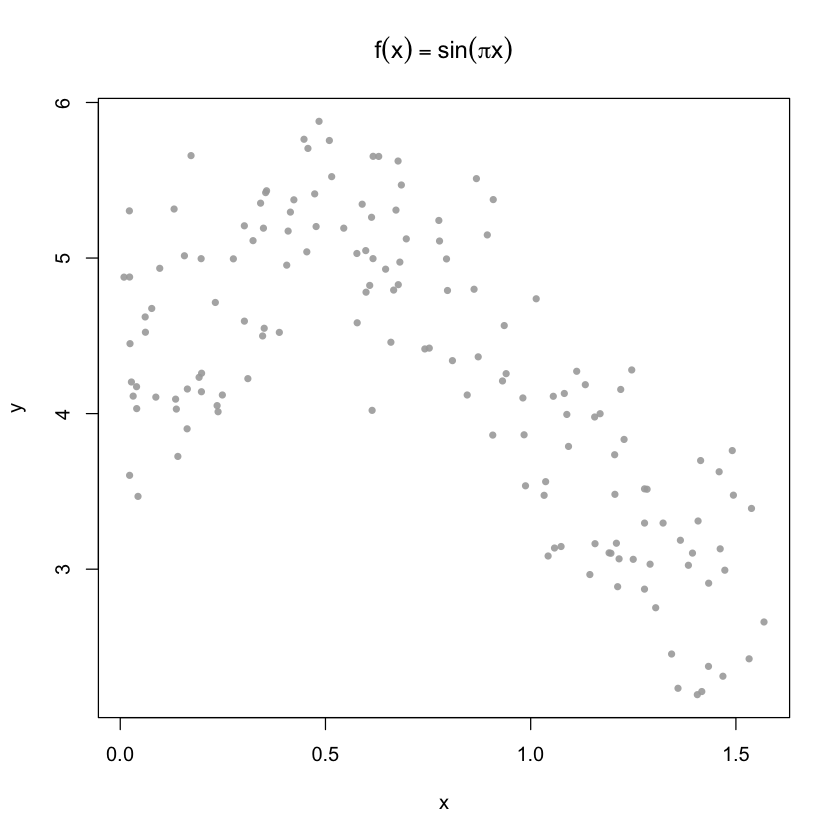

In [2]:
set.seed(888)
library(ggplot2)
n = 150
x = runif(n, 0, pi/2)
y = sin(pi*x) + rnorm(n, 0, 0.5) + 4
plot(y ~ x, main = expression(f(x) == sin(pi*x)), pch = 16, cex = 0.8, col = alpha('darkgrey', 0.9))


Yes, it will. 

#### (b) Use the ksmooth() function to plot some kernel estimators of the unknown function $Y = f(x)$. Explore different possibilities for kernel functions (e.g., box/uniform, Gaussian/normal), and different bandwidths. Which combination gives the best fit?

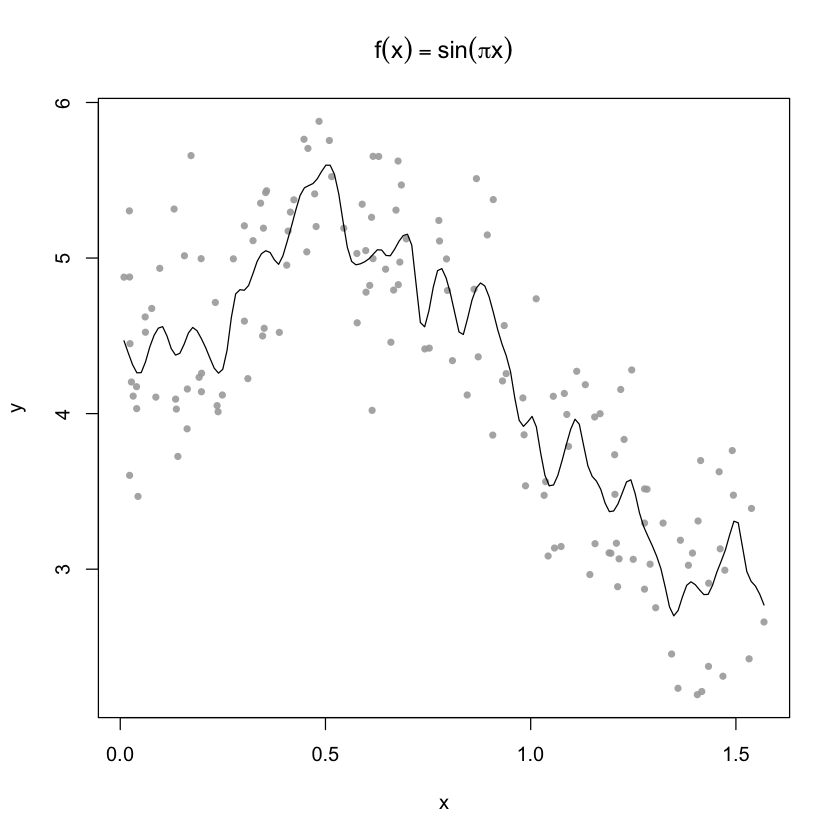

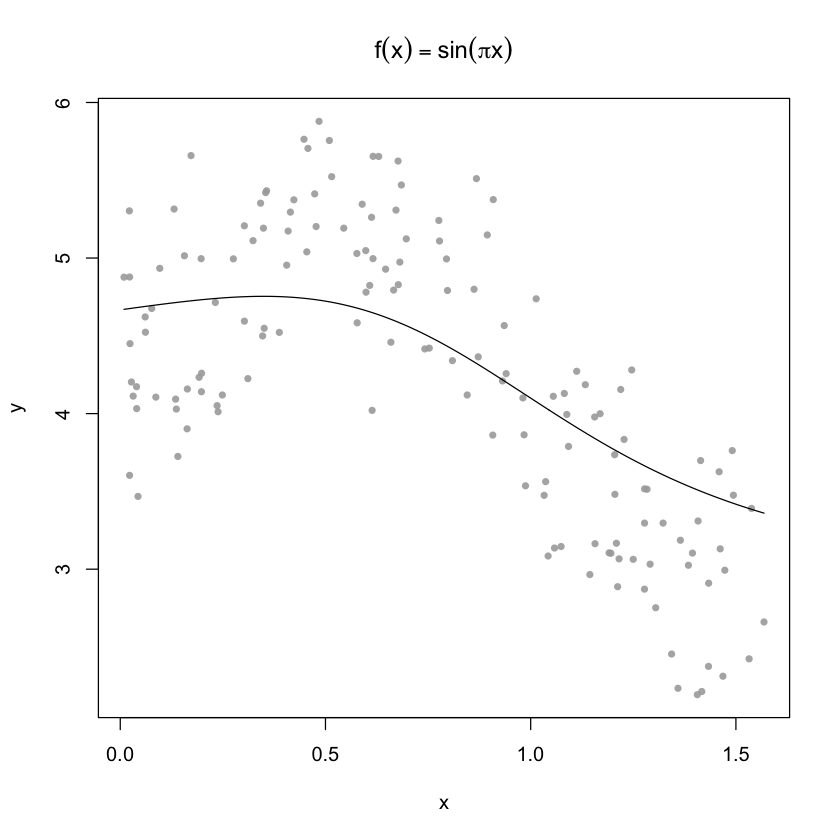

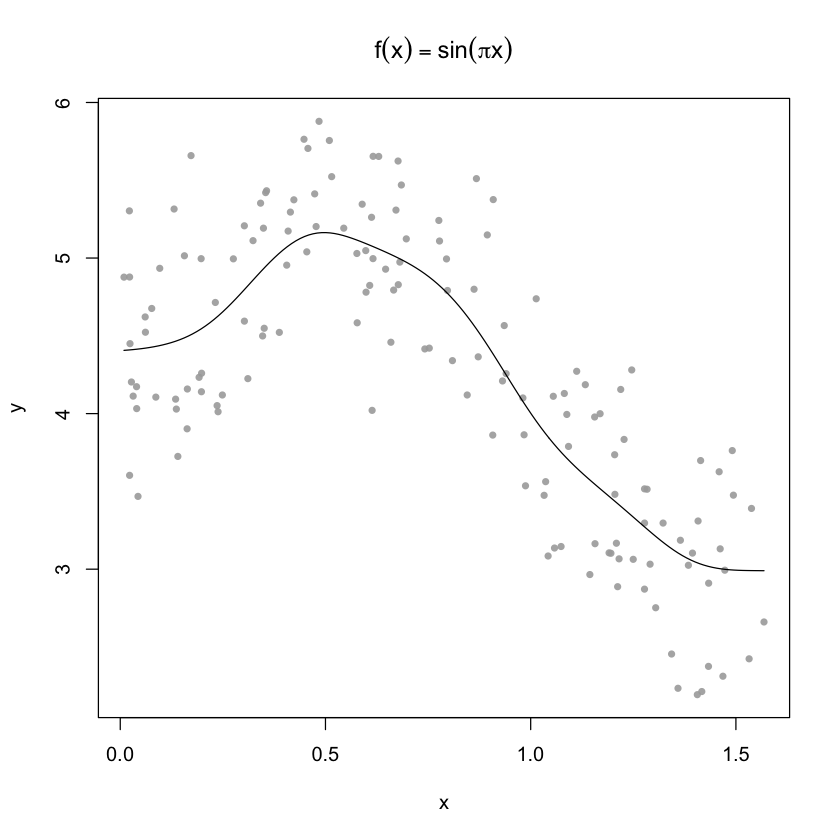

In [3]:
plot(y ~ x, main = expression(f(x) == sin(pi*x)), pch = 16, cex = 0.8, col = alpha('darkgrey', 0.9))
lines(ksmooth(x,y, 'normal', 0.05))

plot(y ~ x, main = expression(f(x) == sin(pi*x)), pch = 16, cex = 0.8, col = alpha('darkgrey', 0.9))
lines(ksmooth(x,y, 'normal', 1))

plot(y ~ x, main = expression(f(x) == sin(pi*x)), pch = 16, cex = 0.8, col = alpha('darkgrey', 0.9))
lines(ksmooth(x,y, 'normal', 0.3))


The last model $0.03$ gives the best fit. 

In [4]:
#predictions?
ksmooth(x, y, "normal", 0.3, x.points = 0.5)

$x
[1] 0.5

$y
[1] 5.163532

#### (c) <span style="color: #CFB87C;">(STAT 5010 Students Only)</span> Write your own function that replicates ksmooth (pick your favorite kernel). That is, write a kernel smoother function that takes in the $(x,y)$ pairs and a value for $\lambda$,  and returns a vector of values for $\widehat f$. Then, plot your kernel smooth over the simulated data from the previous parts.

In [ ]:
#YOUR CODE HERE
fail() # No Answer - remove if you provide an answer

## Problem #2

#### Using the dataset from above, construct a smoothing spline estimator of $f(x)$. 

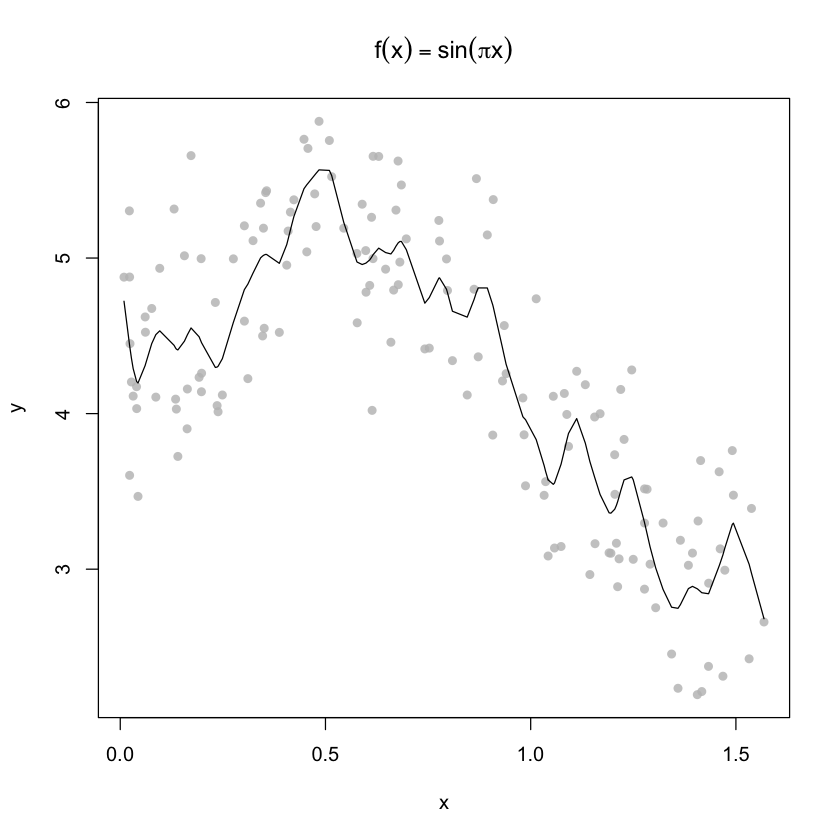

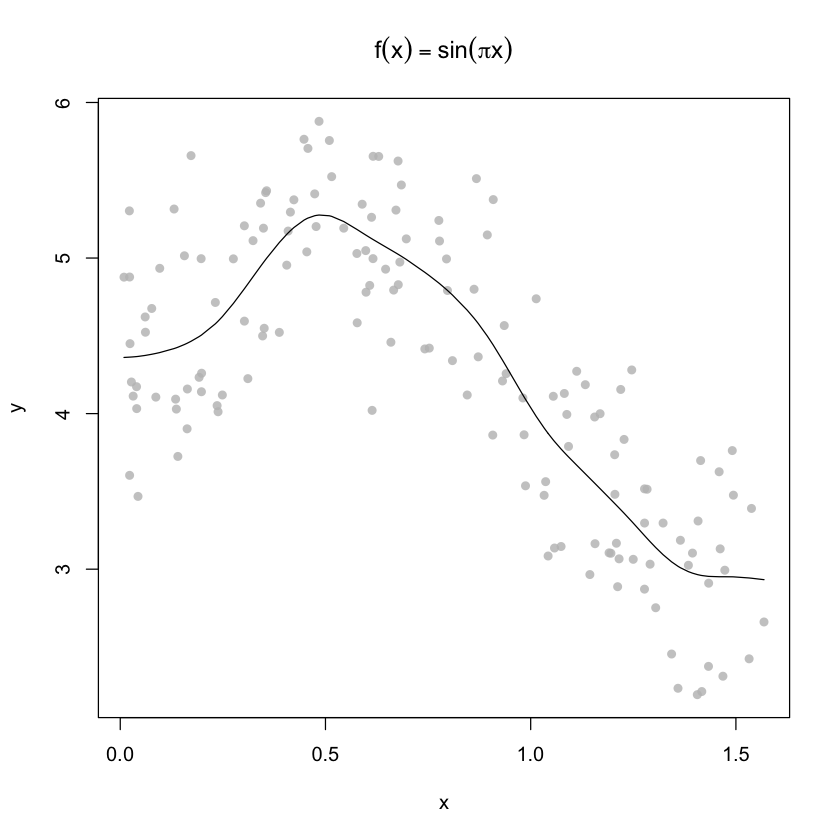

In [5]:
plot(y ~ x, main = expression(f(x) == sin(pi*x)), pch = 16, col = alpha("grey", 0.8))
lines(smooth.spline(x, y, spar = 0.5))

plot(y ~ x, main = expression(f(x) == sin(pi*x)), pch = 16, col = alpha("grey", 0.8))
lines(smooth.spline(x,y))

## Problem #3: GAMs with Simulated Data

In this example, we show how to check the validity of a GAM (using the gam() function in R), through simulated data. This allows us to try and understand the intricacies of gam() without having to worry about the context of the data. Can we adapt this to our model, to generate a synthetic response/death count given the real predictors?

First, we construct three predictor variables. The goal here is to construct a GAM with different types of predictor terms (e.g., factors, continuous variables, some that will enter linearly/parametrically, some that enter transformed).

1. x1: A continuous predictor that, we will suppose has a nonlinear relationship with the response.
2. x2: A categorical variable that takes values in $\{s, m, t\}$.
3. x3: A categorical variable with two levels.

In [6]:
library(ggplot2)
set.seed(12)

#construct predictors 
n = 100
d <- data.frame(
   x1=rnorm(n, mean = 45, sd = 15),
   x2=as.factor(sample(c('s','m','t'),size=n,replace=TRUE)),
   x3=sample(c(F,T),size=n,replace=TRUE),
 stringsAsFactors=F)
#log(d$x1^2)

Then, we make the response some nonlinear/nonparametric function of x1. In a realworld situation, we wouldn't know this functional relationship and would estimate it. Other terms are modeled parametrically. The response has normal noise.

The model here is a Poisson GAM, with true relationship $$\log(\mu_i) = \beta_1 + log(0.5x_1^2) - x_2 + x_3.$$
Note that 

1. the construction of $\mu$ has the linear predictor exponentiated, because of the nature of the link function. 
2. We use $\mu$ to construct $y$. The assumption for Poisson regression is that $Y_i$ is Poisson with mean $\mu_i$. 
3. as.integer(as.factor(VARIABLE)) converts the labels of VARIABLE to 1, 2, 3,.. so that we can construct the relationship for these factors.

x1,x2,x3,mu,y
22.79149,t,FALSE,35.15008,44
68.65754,s,TRUE,2356.92904,2316
30.64883,s,FALSE,172.78395,192
31.19992,s,TRUE,486.71754,476
15.03537,t,FALSE,15.29710,17
40.91556,s,FALSE,307.93036,302


       x1        x2         x3                mu                y         
 Min.   :12.76   m:29   Mode :logical   Min.   :  11.02   Min.   :  14.0  
 1st Qu.:36.55   s:35   FALSE:52        1st Qu.: 262.63   1st Qu.: 261.0  
 Median :43.36   t:36   TRUE :48        Median : 515.13   Median : 518.0  
 Mean   :44.53                          Mean   : 942.47   Mean   : 942.2  
 3rd Qu.:52.64                          3rd Qu.:1173.94   3rd Qu.:1190.8  
 Max.   :76.08                          Max.   :7867.05   Max.   :7847.0  

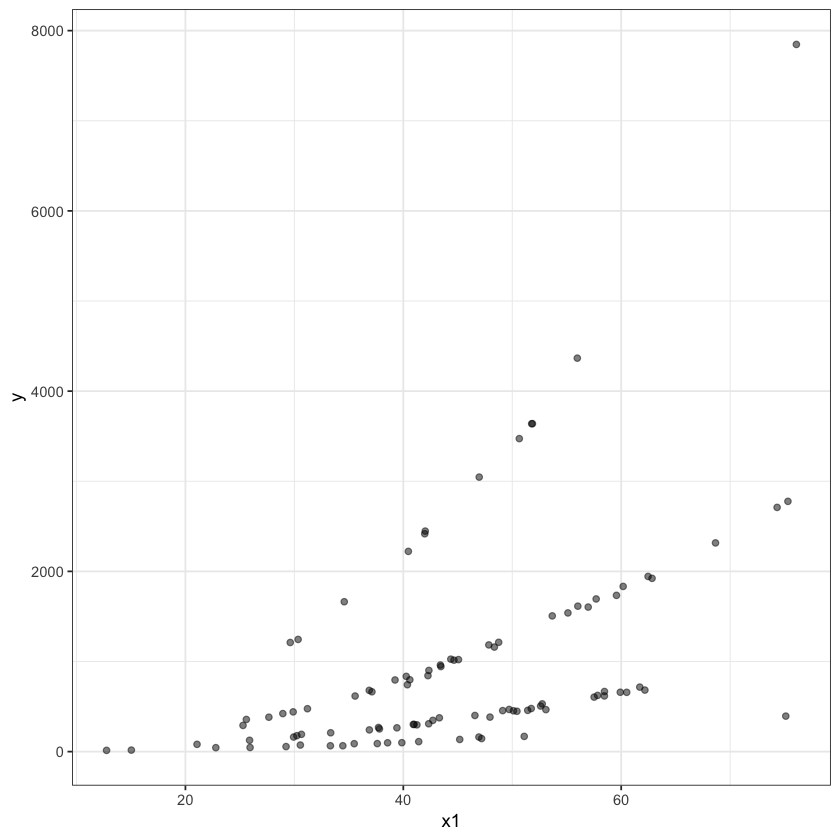

In [7]:
library(ggplot2)

#construct response
d$mu = with(d, exp(log(0.5*x1^2) - as.integer(as.factor(x2)) 
                   + as.integer(as.factor(x3))))

d$y = rpois(n, d$mu); 

ggplot(d, aes(x1,y)) + 
    geom_point(alpha = 0.5) + 
    theme_bw()

head(d) #simulated mean values
summary(d)


Let's run a generalized linear model and show why this model doesn't fit all that well. The fit will be distorted by the log relationship with $x_1$. Then we'll fit a GAM.

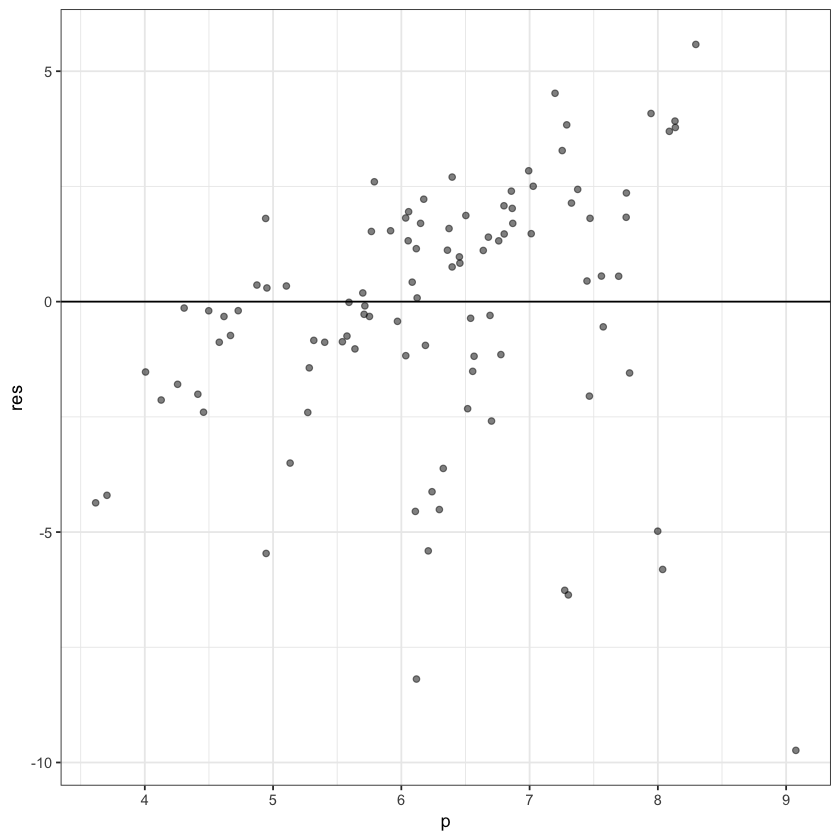

In [8]:
glmod = glm(y ~ x1 + x2 + x3, d, family = poisson)


#residual plot
res = residuals(glmod, type="deviance") #compute the deviance residuals
p = predict(glmod, type = "link")
d_glm = data.frame(p, res)
ggplot(d_glm,aes(p, res)) + 
    geom_point(alpha = 0.5) + 
    geom_hline(yintercept = 0) + 
    theme_bw()


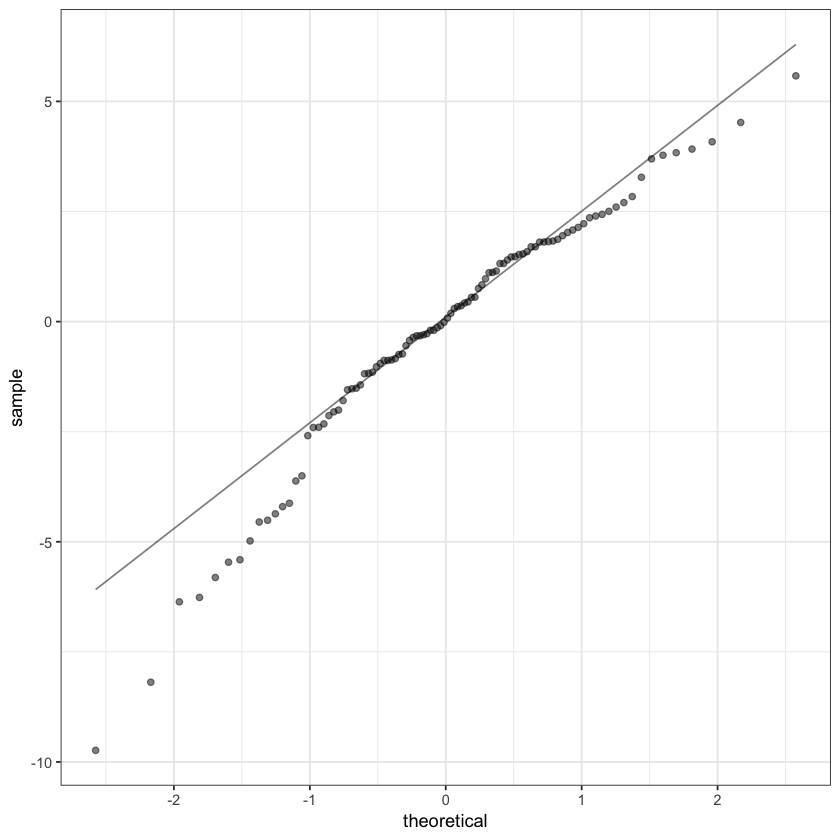

In [9]:
## qqplot
ggplot(d_glm,aes(sample = res)) + 
    stat_qq( alpha = 0.5) + stat_qq_line( alpha = 0.5) +
    theme_bw()

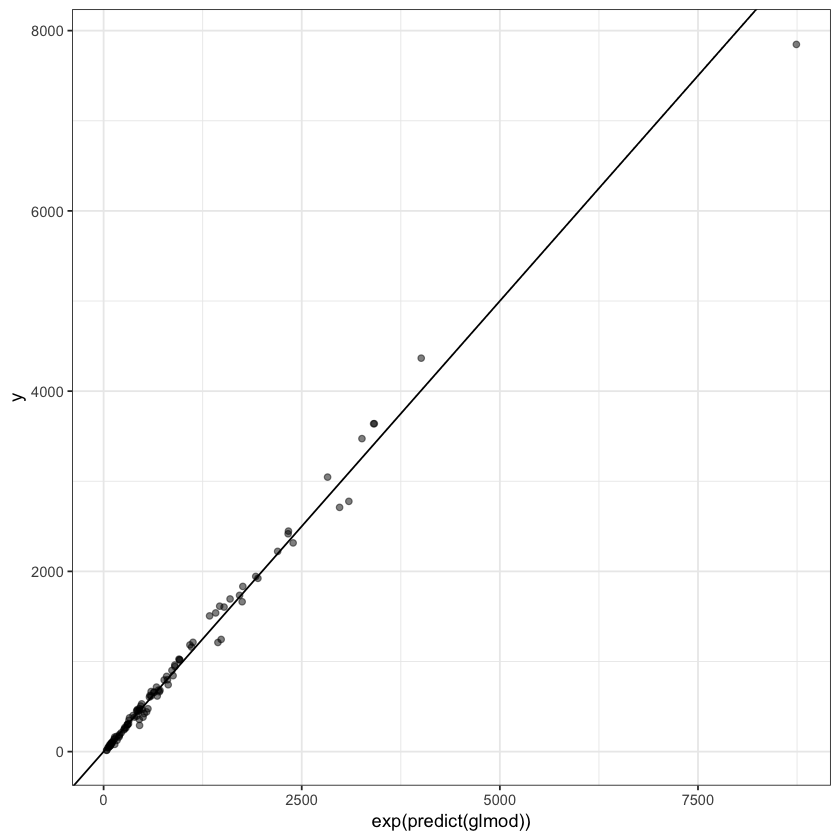

In [10]:
#fitted vs actual
ggplot(d,aes(exp(predict(glmod)),y)) + 
    geom_point(alpha = 0.5) +
    geom_abline(slope=1) + 
    theme_bw()

In [11]:
mseGLM = with(d_glm, mean(res^2)); mseGLM

[1] 7.906279

Notice above that the residual plots aren't horrible, but there's some skew. And, the QQ plot doesn't look good. We'll also see that the prediction error is higher than using a GAM. **The MSE for this model is 7.9**.

If we fit the model with using the known relationship, we get a better fit. See below. Of course we can't ever do that in practice (without good theory) or through guessing. 

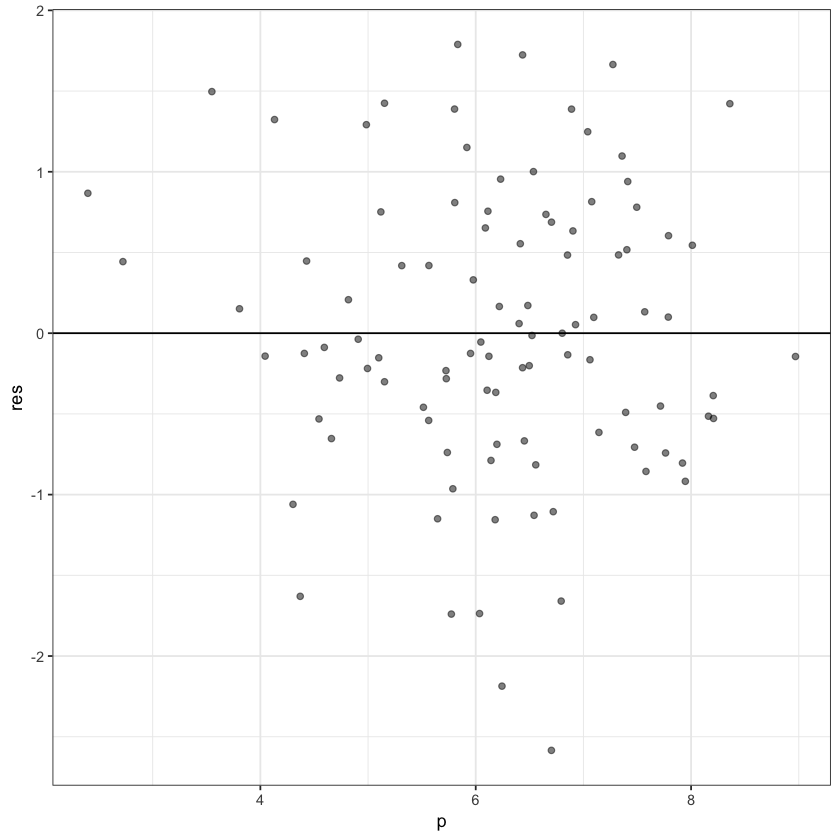

In [12]:
glmod2 = glm(y ~ log(0.5*x1^2) + x2 + x3, d, family = poisson)
pred_error = sum((exp(predict(glmod2))-d$y)^2); #pred_error

#residual plot
res = residuals(glmod2, type="deviance") #compute the deviance residuals
p = predict(glmod2, type = "link")
d_exact = data.frame(p, res)
ggplot(d_exact,aes(p, res)) + 
    geom_point(alpha = 0.5) + 
    geom_hline(yintercept = 0) + 
    theme_bw()

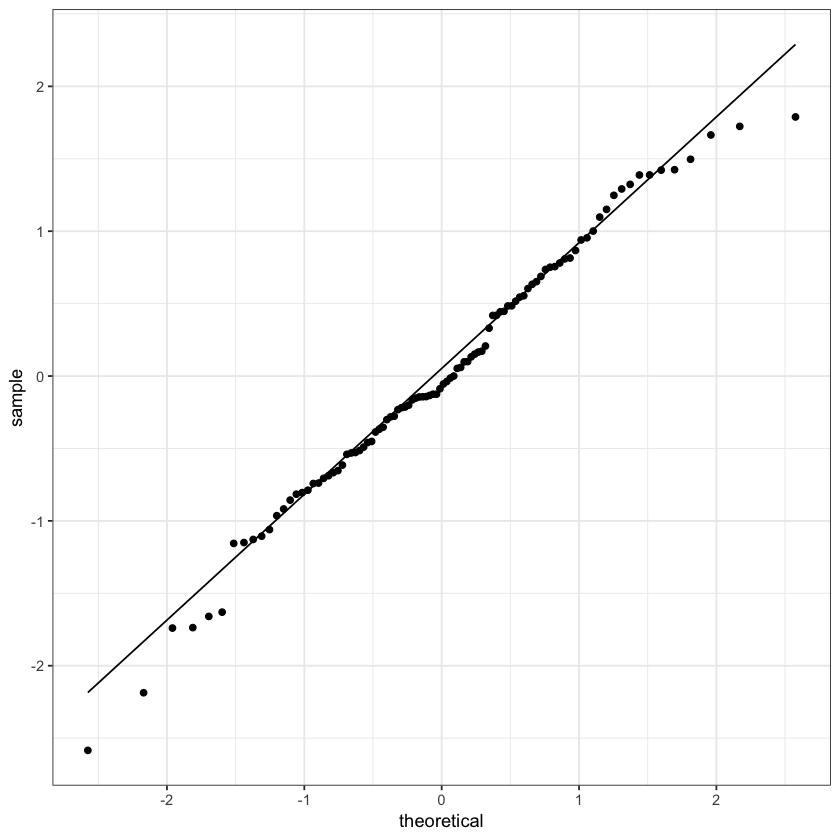

In [13]:
## qqplot
ggplot(d_exact,aes(sample = res)) + 
    stat_qq() + stat_qq_line() +
    theme_bw()

#fitted vs actual


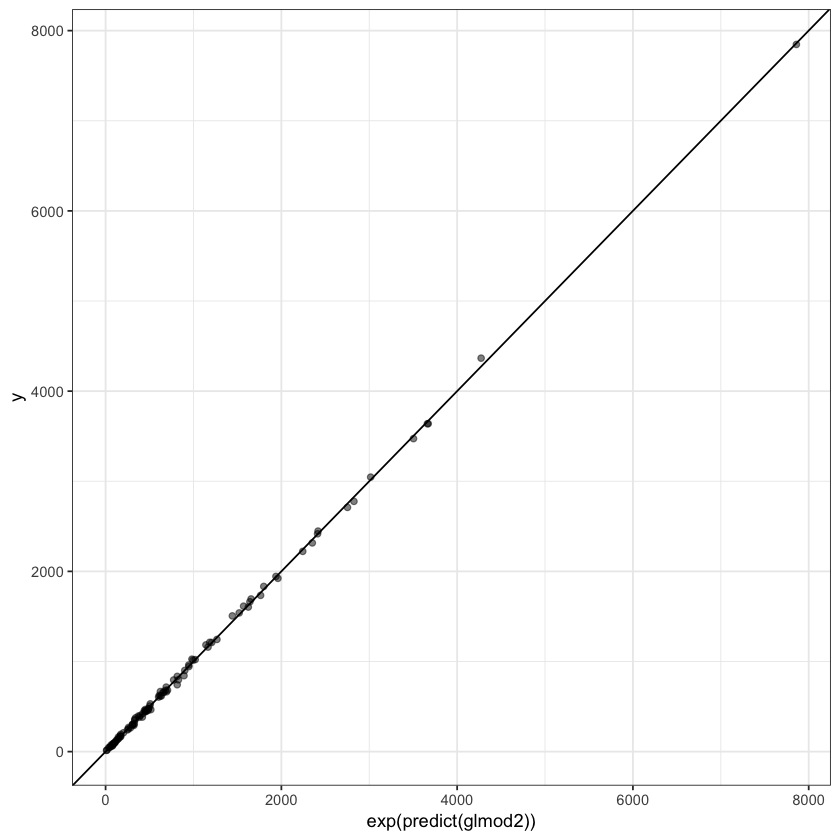

In [14]:
ggplot(d,aes(exp(predict(glmod2)),y)) + 
    geom_point(alpha = 0.5) + 
    geom_abline(slope=1) + 
    theme_bw()


In [15]:
mse_exact = with(d_exact, mean(res^2)); mse_exact

[1] 0.77512

The fits look much better, as to be expected. **The MSE for this model is 0.775,** which is much lower than above.

So, when we don't know the true relationship, we try to estimate it using GAMs.

Loading required package: nlme
This is mgcv 1.8-28. For overview type 'help("mgcv-package")'.


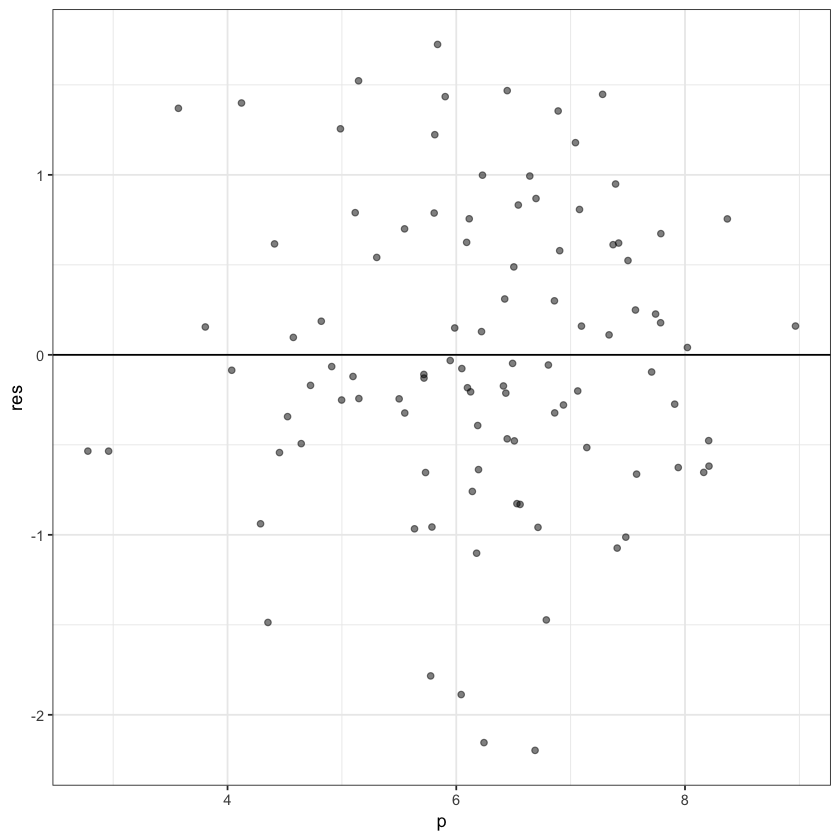

In [16]:
library(mgcv)
modGAM = gam(y ~ s(x1) + x2 + x3, data=d, family = poisson)

res = residuals(modGAM, type="deviance") #compute the deviance residuals

#residual and QQ plot
res = residuals(modGAM, type="deviance") #compute the deviance residuals
p = predict(modGAM, type = "link")
d_gam = data.frame(p, res)
ggplot(d_gam,aes(p, res)) + 
    geom_point(alpha = 0.5) + 
    geom_hline(yintercept = 0) + 
    theme_bw()

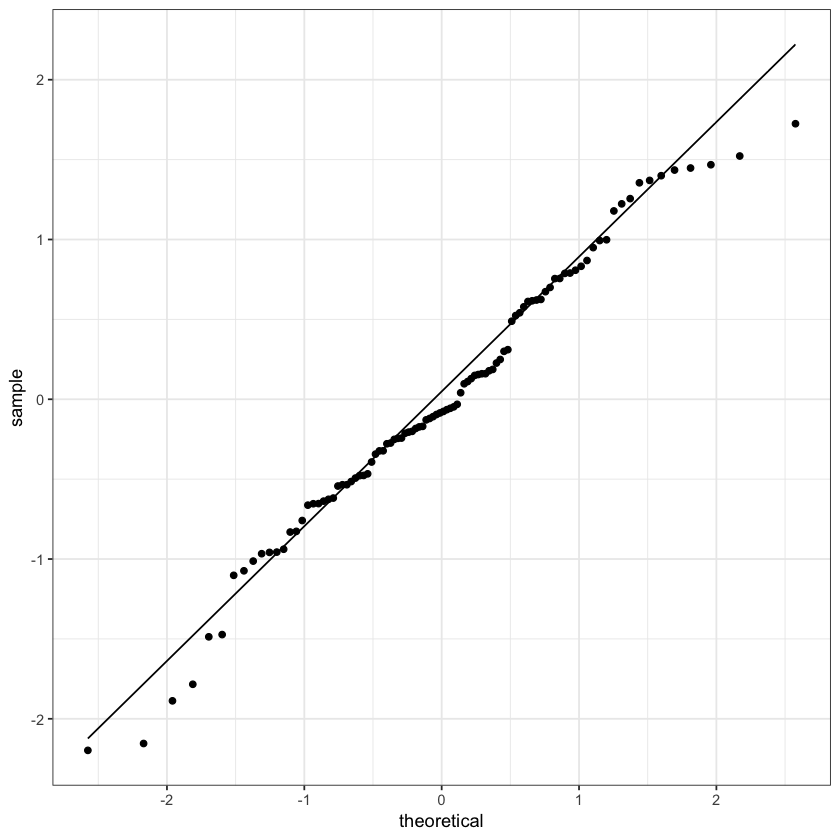

In [17]:
## qqplot
ggplot(d_gam,aes(sample = res)) + 
    stat_qq() + stat_qq_line() +
    theme_bw()

In [18]:
mseGAM = with(d_gam, mean(res^2)); mseGAM

[1] 0.6844638


Method: UBRE   Optimizer: outer newton
full convergence after 6 iterations.
Gradient range [2.13464e-12,2.13464e-12]
(score -0.1016859 & scale 1).
Hessian positive definite, eigenvalue range [0.0132722,0.0132722].
Model rank =  13 / 13 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

        k'  edf k-index p-value
s(x1) 9.00 6.69    1.24    0.98



Family: poisson 
Link function: log 

Formula:
y ~ s(x1) + x2 + x3

Parametric coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  6.805734   0.007554   901.0   <2e-16 ***
x2s         -1.000786   0.007438  -134.6   <2e-16 ***
x2t         -2.017944   0.011907  -169.5   <2e-16 ***
x3TRUE       1.014461   0.008283   122.5   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
        edf Ref.df Chi.sq p-value    
s(x1) 6.693  7.722  23652  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =      1   Deviance explained = 99.9%
UBRE = -0.10169  Scale est. = 1         n = 100

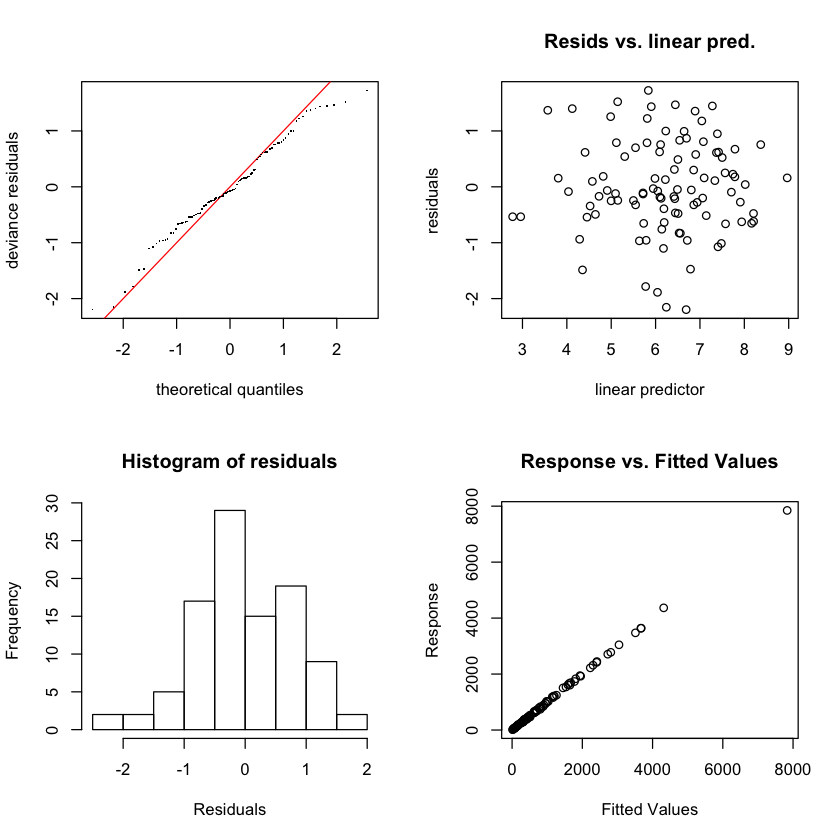

In [19]:
gam.check(modGAM)
summary(modGAM)

The ‘edf’ is the estimated degrees of freedom – essentially, the larger the number, the more wiggly the fitted model. Values of around 1 tend to be close to a linear term. For a reference, in our video introducing additive models ([Unit #7 Lesson 6](https://youtu.be/8-iVcbicEA0)), on slide 34, based on the plot of the predictor ibt against the response O3, we suggested a line would fit between the confidence bands. The edf of ibt was 2.112.

In [20]:
mseGLM = with(d_glm, mean(res^2)); mseGLM
mse_exact = with(d_exact, mean(res^2)); mse_exact
mseGAM = with(d_gam, mean(res^2)); mseGAM

[1] 7.906279

[1] 0.77512

[1] 0.6844638

Let's look at predictions

In [21]:
set.seed(101)
n = 10
d_predict = data.frame(
   x1=rnorm(n, mean = 45, sd = 15),
   x2=as.factor(sample(c('s', 'm', 't'),size=n,replace=TRUE)),
   x3=sample(c(T,F),size=n,replace=TRUE),
 stringsAsFactors=F)
d_predict
true_mu = with(d_predict, exp(log(0.5*x1^2) - as.integer(as.factor(x2)) + as.integer(as.factor(x3))));

eta = log(true_mu)
p_glm = predict(glmod, d_predict, type = "link"); #head(p_glm)
p_exact = predict(glmod2, d_predict, type = "link"); #head(p_exact)
p_gam = predict(modGAM, d_predict, type = "link"); #head(p_gam)


p_mse_glm = mean((p_glm - eta)^2); p_mse_glm
p_mse_exact =  mean((p_exact - eta)^2); p_mse_exact
p_mse_gam =  mean((p_gam - eta)^2); p_mse_gam

x1,x2,x3
40.10945,m,FALSE
53.28693,t,FALSE
34.87584,t,FALSE
48.21539,s,FALSE
49.66154,t,TRUE
62.60949,s,FALSE
54.28185,m,FALSE
43.30899,s,FALSE
58.75542,s,TRUE
41.65111,t,TRUE


[1] 0.002868862

[1] 0.0001149316

[1] 0.0002652536

Here, we see that the predicted MSE for the original GLM, the exact GLM fit, and the GAM are 0.0028, 0.0001, and 0.0003, respectively. This is about what we should expect: the GAM does better than the GLM, but not better than the model that uses knowledge of the exact fit.

Finally, let's plot the transformation of the predictor chosen by the gam fit. 

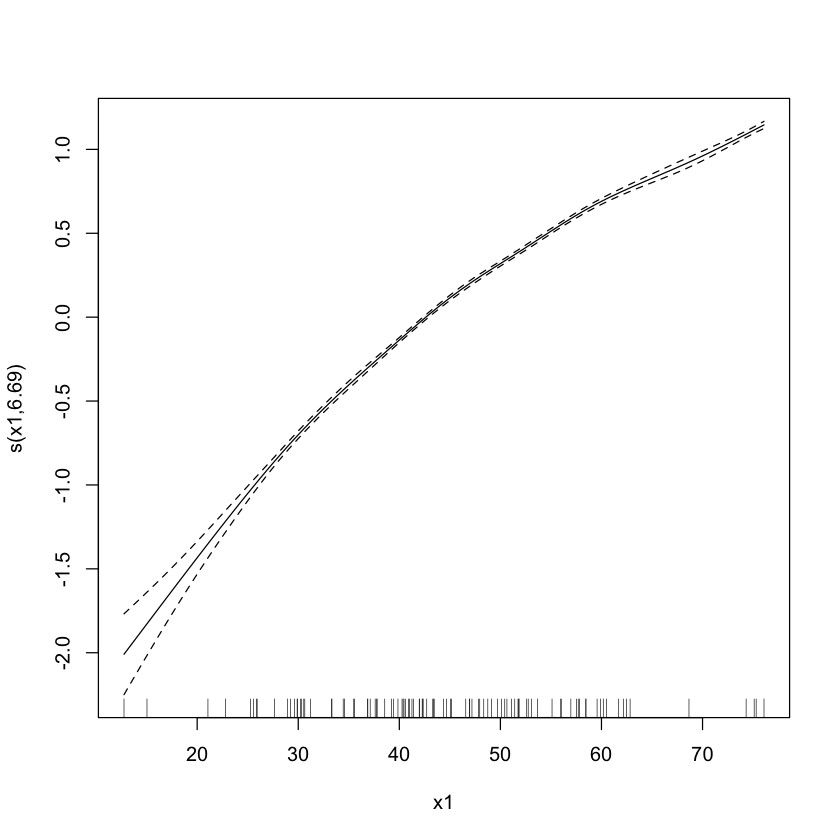

In [22]:
plot.gam(modGAM, se = T) 

The solid line is the predicted value of the dependent variable (log of the mean) as a function of $x_1$, holding all other predictors constant ("adjusting" for them). The se=TRUE plots two times the standard errors of the estimates (the dashed lines). The small lines along the x axis are the "rug", showing the location of the sample plots. The y axis is in the linear units, which in this case is $\log(\lambda)$.

Because of the additive structure, we get to see how the log of the mean changes as a function of $x_1$. We could ask the question: would a linear fit do better? We can answer by asking whether a straight line would fit between the confidence bands. In this case, it wouldn't, and so we might conclude that some nonlinear fit is necessary.

## Problem #4

The fat dataset gives percentage of body fat, age, weight, height, and 10 body circumference measurements for 252 men. Body fat is estimated through an underwater weighing technique, but this is inconvenient to use widely. Develop an additive model that allows the estimation of body fat for men using only a scale and measuring tape. Your model should predict % body fat according to the variable siri. You may not use Brozek's % body fat, density, or free (fat free weight) as predictors.

In [26]:
library(mgcv)
#data(fat)
fat = read.table("https://www.colorado.edu/amath/sites/default/files/attached-files/fat.txt",
        sep = "\t", header = TRUE)
head(fat)

brozek,siri,density,age,weight,height,adipos,free,neck,chest,abdom,hip,thigh,knee,ankle,biceps,forearm,wrist
12.6,12.3,1.0708,23,154.25,67.75,23.7,134.9,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
6.9,6.1,1.0853,22,173.25,72.25,23.4,161.3,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
24.6,25.3,1.0414,22,154.00,66.25,24.7,116.0,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
10.9,10.4,1.0751,26,184.75,72.25,24.9,164.7,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
27.8,28.7,1.0340,24,184.25,71.25,25.6,133.1,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7
20.6,20.9,1.0502,24,210.25,74.75,26.5,167.0,39.0,104.5,94.4,107.8,66.0,42.0,25.6,35.7,30.6,18.8



Family: gaussian 
Link function: identity 

Formula:
siri ~ s(weight) + s(height) + s(neck) + s(chest) + s(abdom) + 
    +s(hip) + s(thigh) + s(knee) + s(ankle) + s(biceps) + s(forearm) + 
    s(wrist)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  19.1508     0.2528   75.75   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
             edf Ref.df      F p-value    
s(weight)  1.000  1.000  0.892 0.34589    
s(height)  1.000  1.000  2.120 0.14678    
s(neck)    1.859  2.374  1.569 0.13715    
s(chest)   1.000  1.000  0.163 0.68665    
s(abdom)   5.652  6.744 28.099 < 2e-16 ***
s(hip)     5.938  7.042  2.195 0.03932 *  
s(thigh)   1.000  1.000  0.013 0.90871    
s(knee)    1.508  1.872  0.331 0.69237    
s(ankle)   1.000  1.000  0.330 0.56623    
s(biceps)  4.821  5.851  1.881 0.06542 .  
s(forearm) 1.000  1.000  0.836 0.36156    
s(wrist)   1.510  1.856  5.889 0.00264 

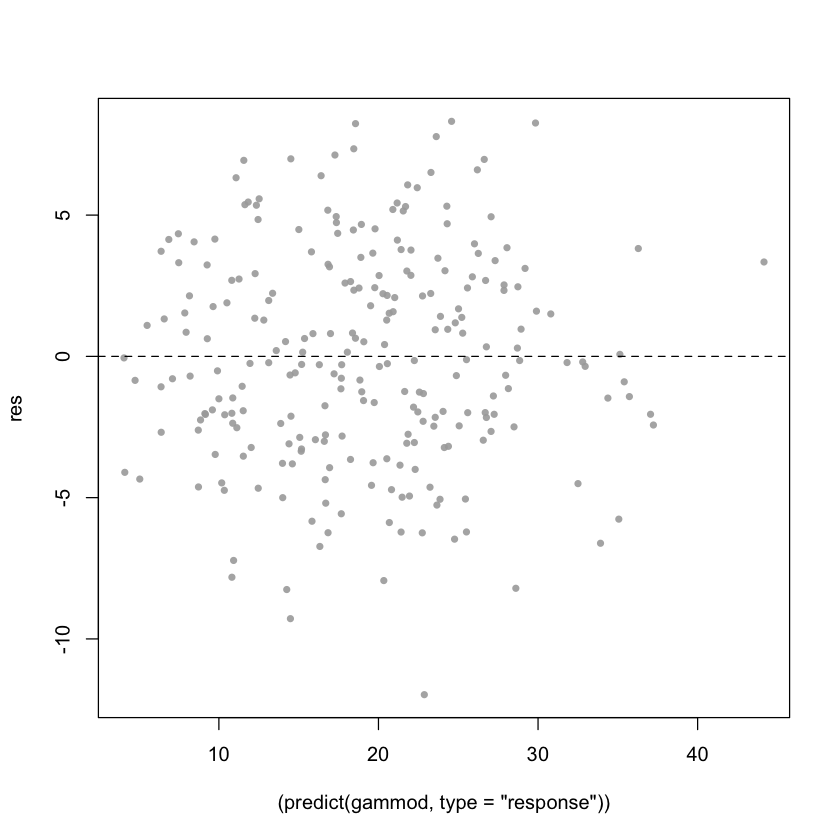

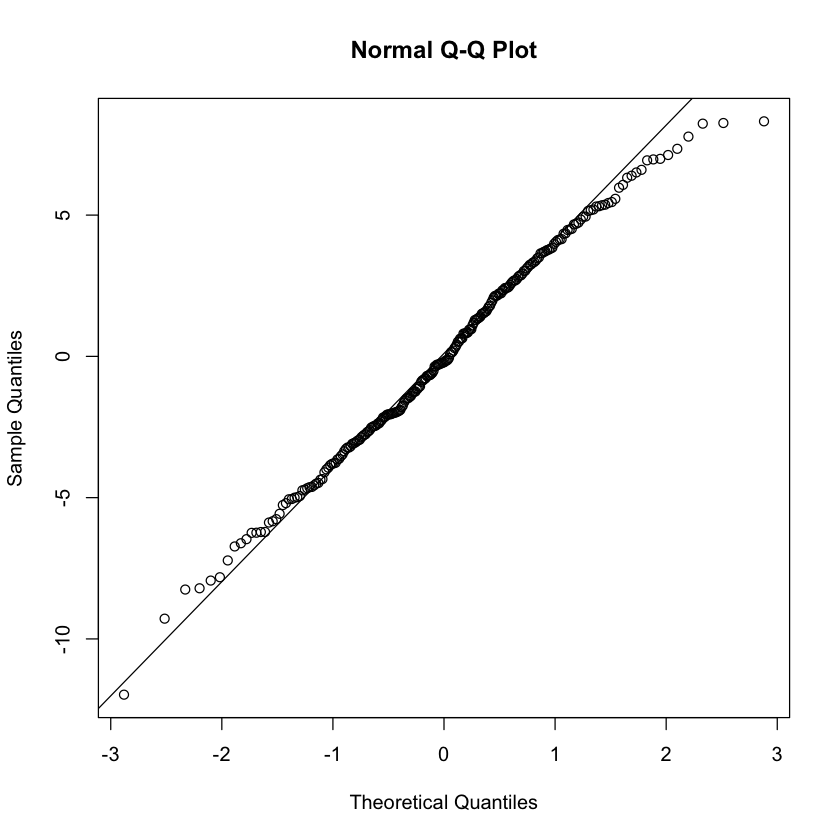

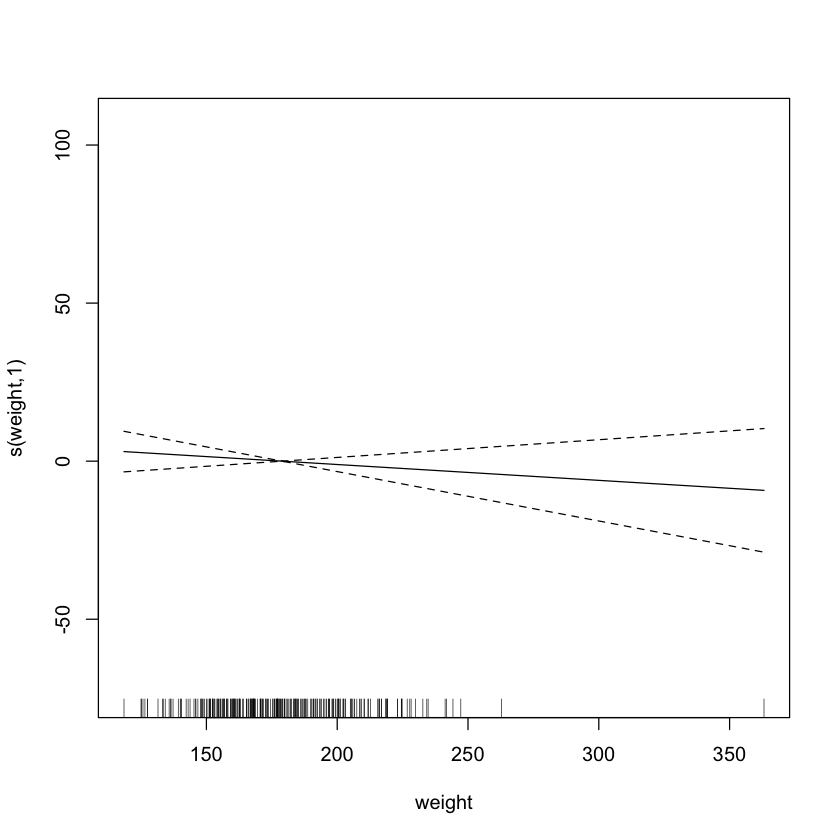

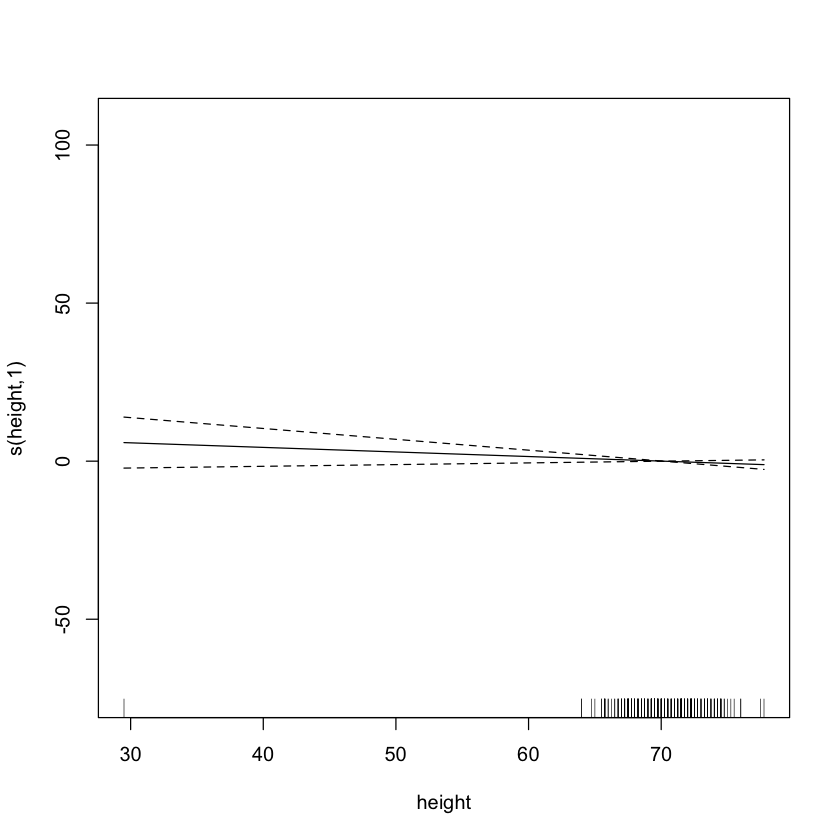

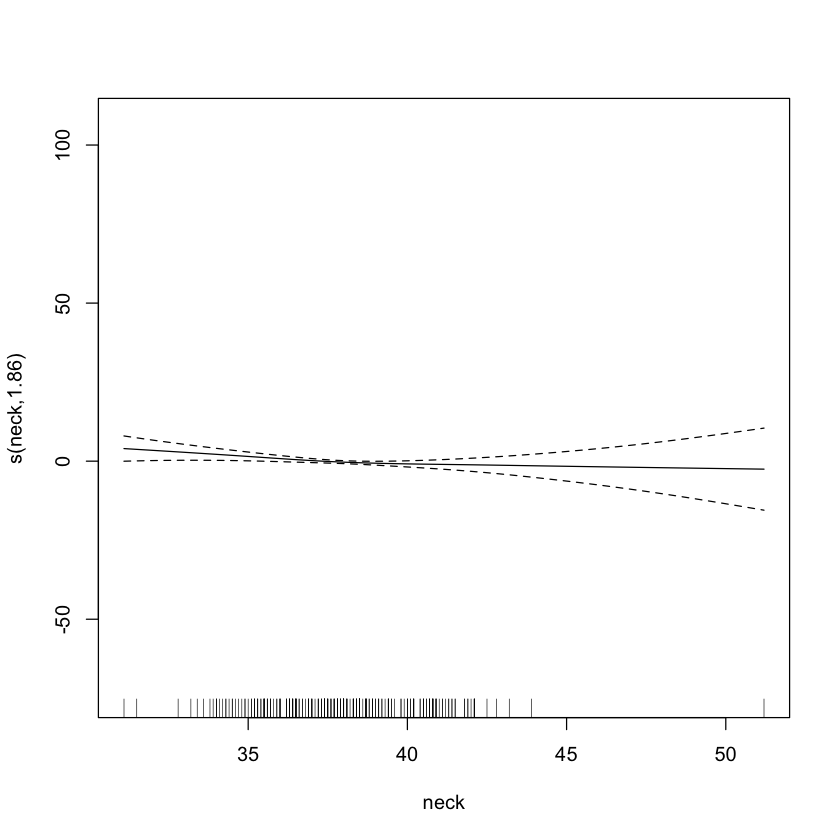

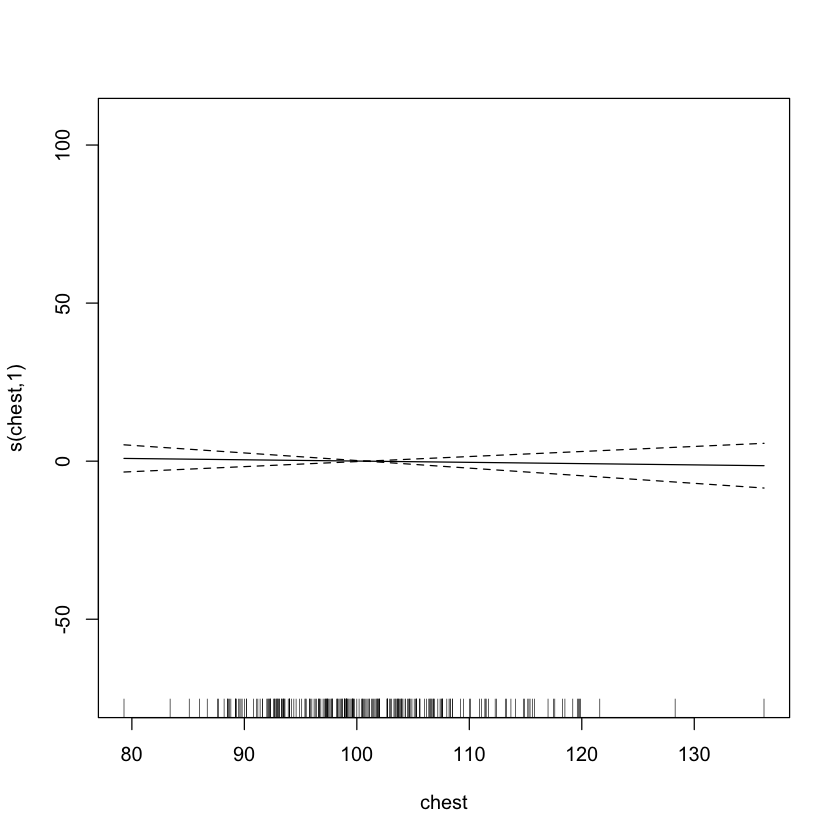

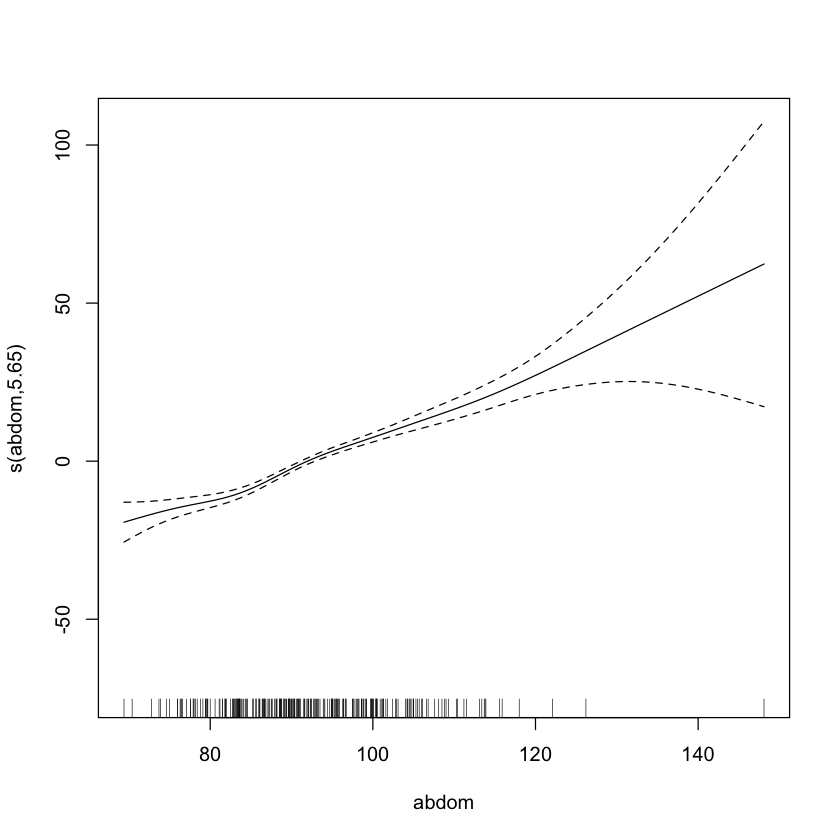

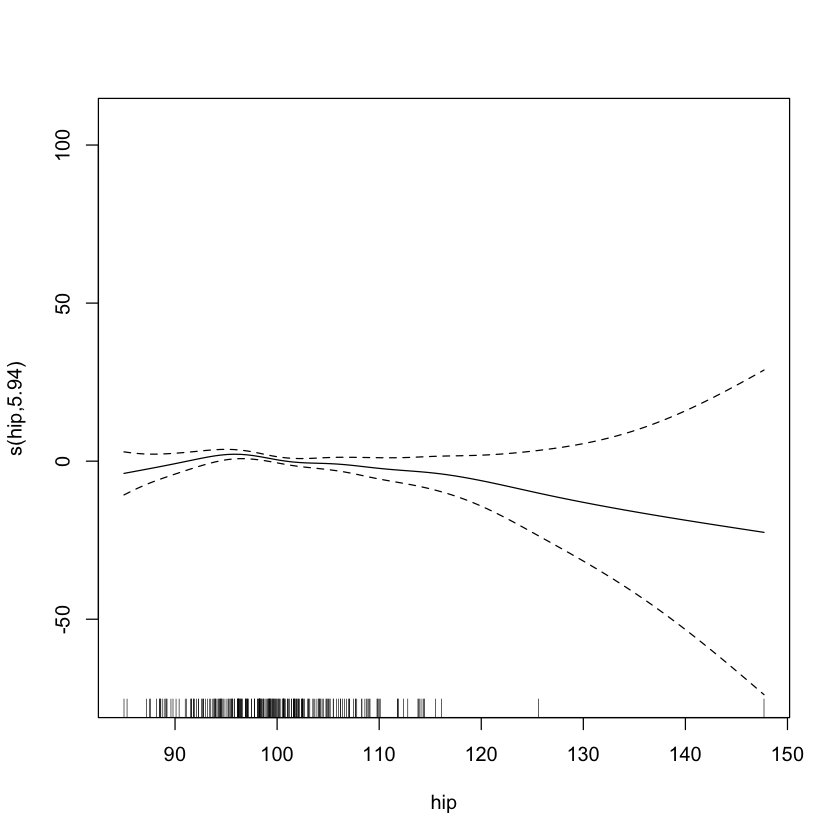

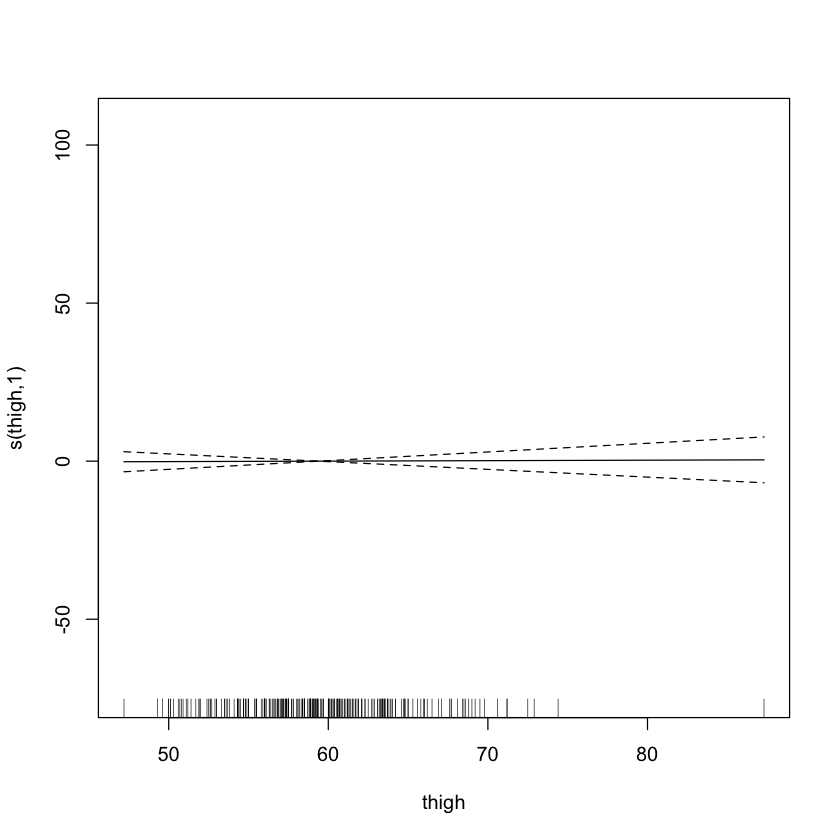

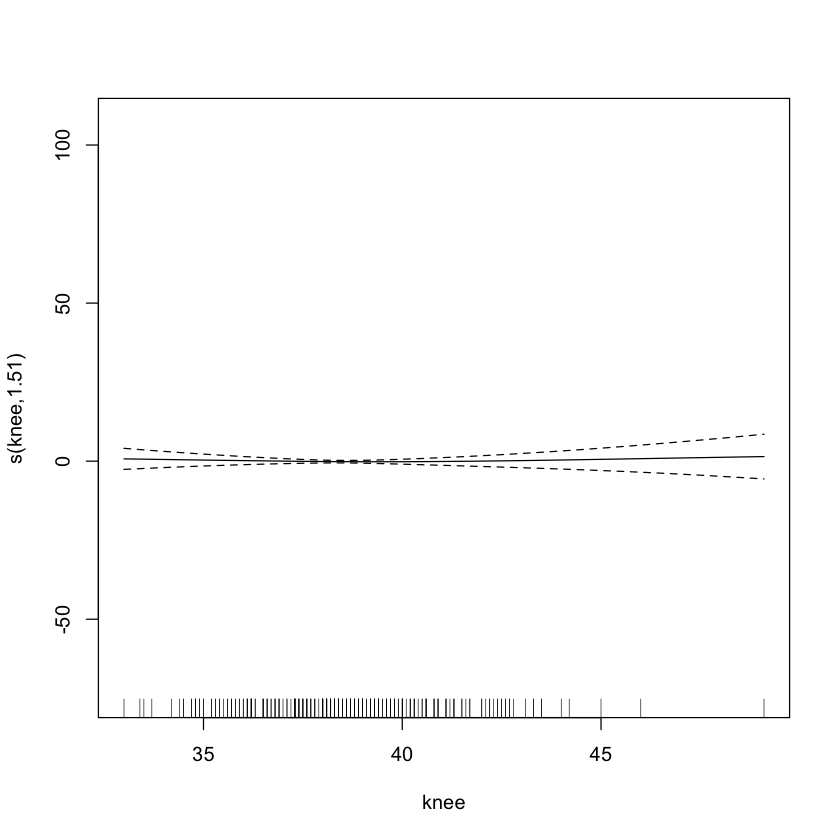

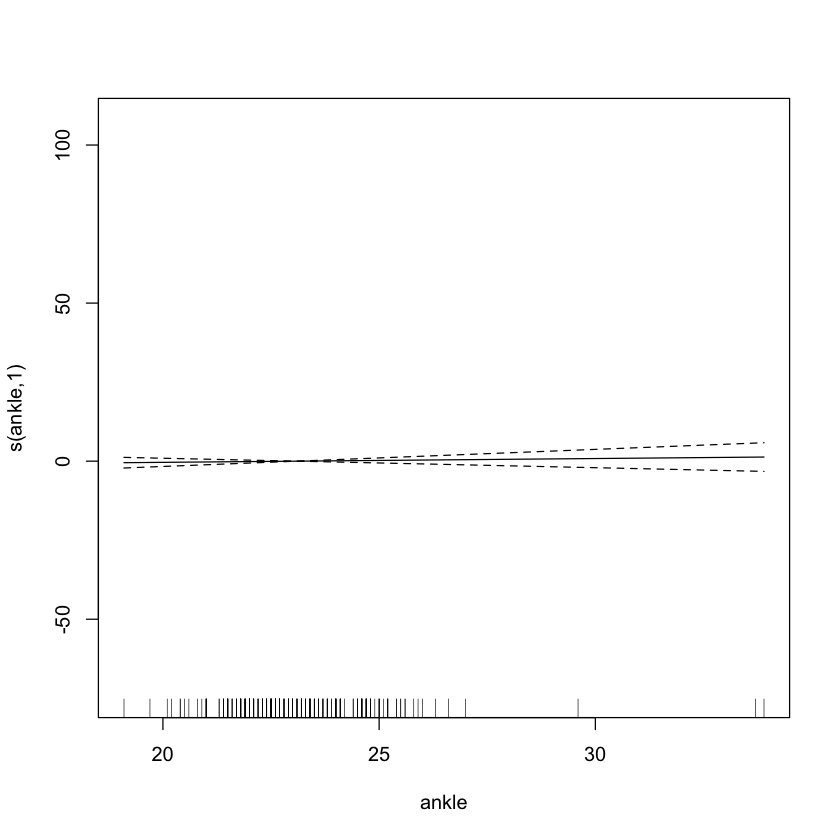

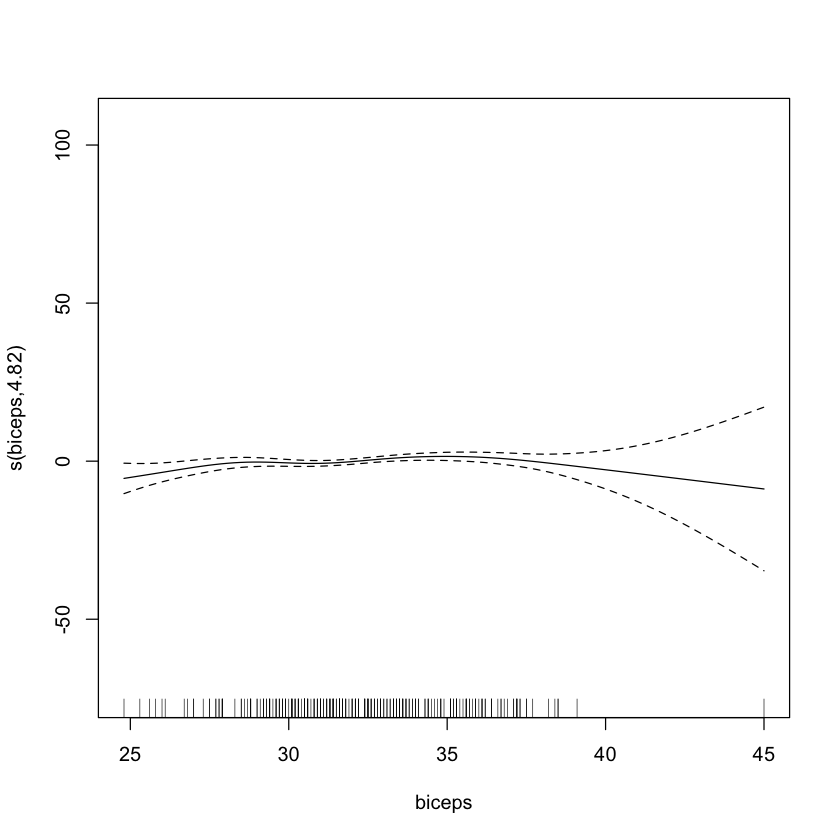

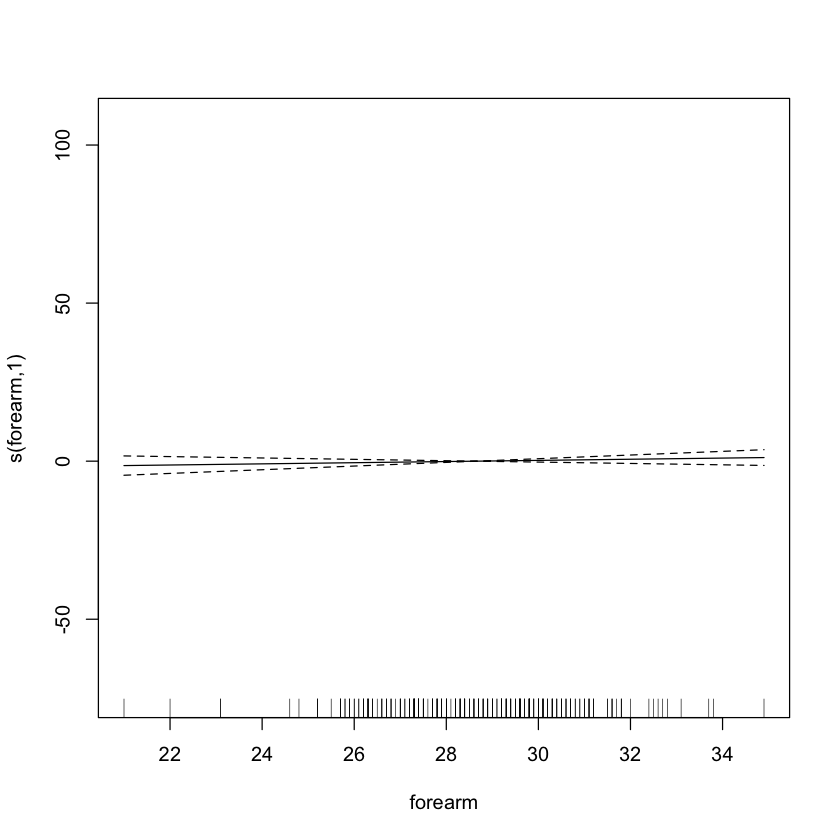

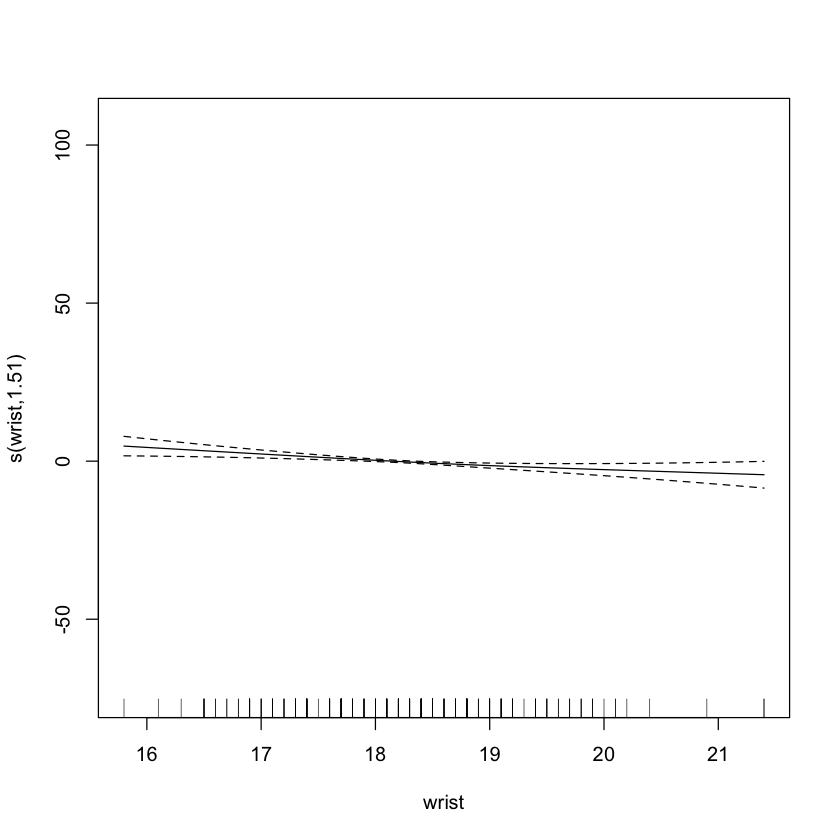

In [30]:
gammod = gam(siri ~ s(weight) + s(height) + s(neck) + s(chest) + s(abdom) + 
            + s(hip) + s(thigh) + s(knee) + s(ankle) + s(biceps) + s(forearm) + s(wrist), data = fat)
summary(gammod)

res = residuals(gammod, type = 'deviance') 

plot((predict(gammod, type = 'response')), res, pch = 16, cex = 0.8, col = alpha('darkgrey', 0.9))
abline(h=0, lty = 2)
qqnorm(res)
qqline(res)
plot.gam(gammod)


In the GAM fit above, there are several interesting features. First, based on the edf(and on the partial plots), weight, height, chest, thigh, ankle, and forearm can enter the model linearly (parametrically). Hip and biceps stand out as variables that should say nonparametric. This is nice because then we can intrepret the coefficient associated with the parametric variables as we would for linear regression. For example: 

In [32]:
gammod = gam(siri ~ weight + height + s(neck) + chest + s(abdom) + s(hip) +
            thigh + s(knee) + ankle + s(biceps) + forearm + s(wrist), data = fat)

summary(gammod)


Family: gaussian 
Link function: identity 

Formula:
siri ~ weight + height + s(neck) + chest + s(abdom) + s(hip) + 
    thigh + s(knee) + ankle + s(biceps) + forearm + s(wrist)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept) 33.42564   15.25205   2.192   0.0294 *
weight      -0.05014    0.05308  -0.945   0.3459  
height      -0.14449    0.09924  -1.456   0.1468  
chest       -0.04037    0.09994  -0.404   0.6867  
thigh        0.01492    0.12997   0.115   0.9087  
ankle        0.12062    0.20997   0.574   0.5662  
forearm      0.18243    0.19954   0.914   0.3616  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
            edf Ref.df      F p-value    
s(neck)   1.859  2.374  1.569 0.13715    
s(abdom)  5.652  6.744 28.099 < 2e-16 ***
s(hip)    5.938  7.042  2.195 0.03932 *  
s(knee)   1.508  1.872  0.331 0.69237    
s(biceps) 4.821  5.851  1.881 0.06542 .  
s(wrist)  1.510  1.856  5

Here, we could say that, if the model is correct, a one pound increase in weight is associated with an average of $\approx 0.05$ decrease in siri (body fat percentage), adjusting for the other predictors (including the smoothed ones). This value is counterintuitive: we might expect to see an increase in bodyfat percentage with an increase in weight. We might notice that the p-value associated with weight is high, which could suggest that the parameter associated with weight is not different form zero. 

But something else if going on here! Notice that all of the p-values are high, and, intuitively, most (if not all) should be associated with the response. This phenomenon is a sign that multicolinearity is present. Mulitcolinearity means that the predictors are highly correlated - or more generally, that one is a near linear combination of the others. We did not cover ways to detect or deal with mulitcolinearity, so you are not responsible for this topic. But if you're intersted, see section 7.3 in Linear Models with R(Second Edition). 

## In-Class Code

A study the relationship between atmospheric ozone concentration and meteorology in the Los Angeles Basin in 1976. A number of cases with missing variables have been removed for simplicity.

In [33]:
library(mgcv)
library(faraway)
data(ozone)
head(ozone)
gammod = gam(O3 ~ s(temp) + s(ibh) + s(ibt), data = ozone)
summary(gammod)

O3,vh,wind,humidity,temp,ibh,dpg,ibt,vis,doy
3,5710,4,28,40,2693,-25,87,250,33
5,5700,3,37,45,590,-24,128,100,34
5,5760,3,51,54,1450,25,139,60,35
6,5720,4,69,35,1568,15,121,60,36
4,5790,6,19,45,2631,-33,123,100,37
4,5790,3,25,55,554,-28,182,250,38



Family: gaussian 
Link function: identity 

Formula:
O3 ~ s(temp) + s(ibh) + s(ibt)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  11.7758     0.2382   49.44   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
          edf Ref.df      F  p-value    
s(temp) 3.386  4.259 20.681 6.93e-16 ***
s(ibh)  4.174  5.076  7.338 1.38e-06 ***
s(ibt)  2.112  2.731  1.400    0.214    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.708   Deviance explained = 71.7%
GCV = 19.346  Scale est. = 18.72     n = 330

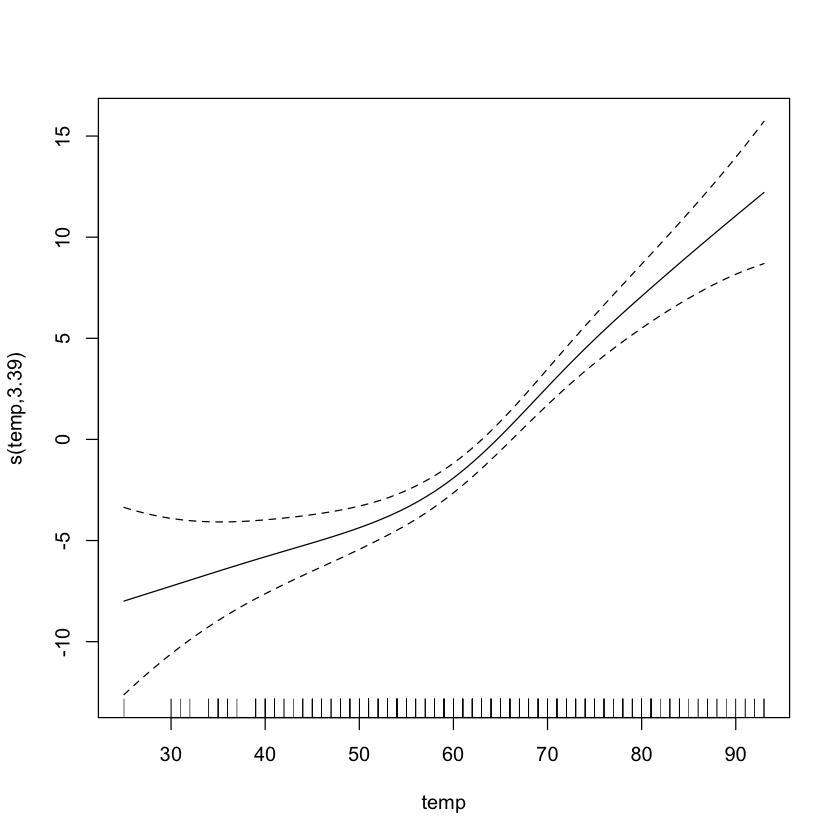

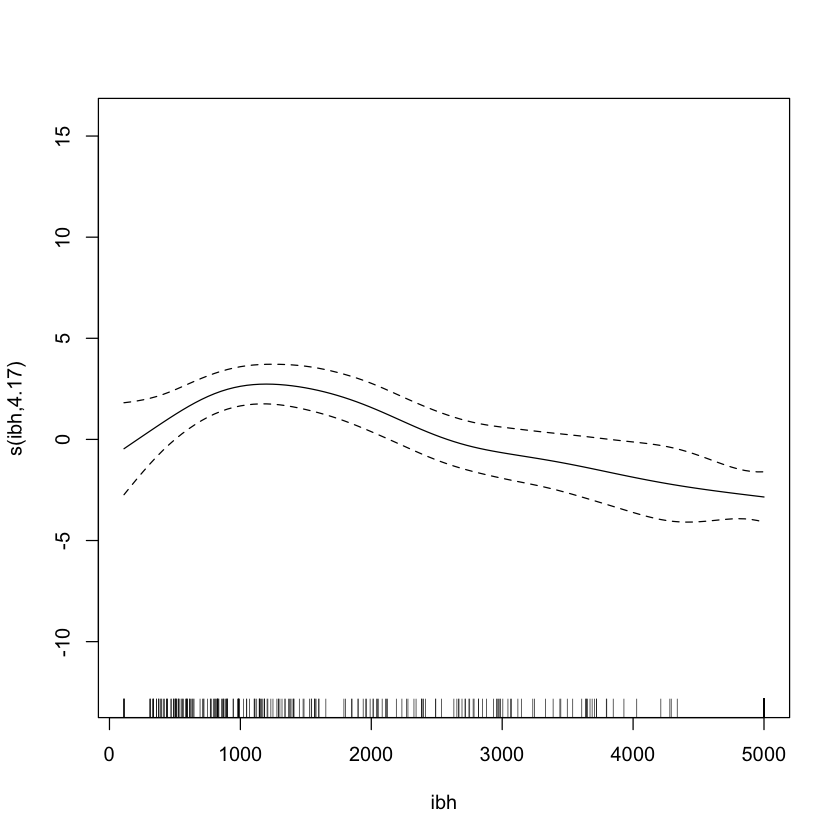

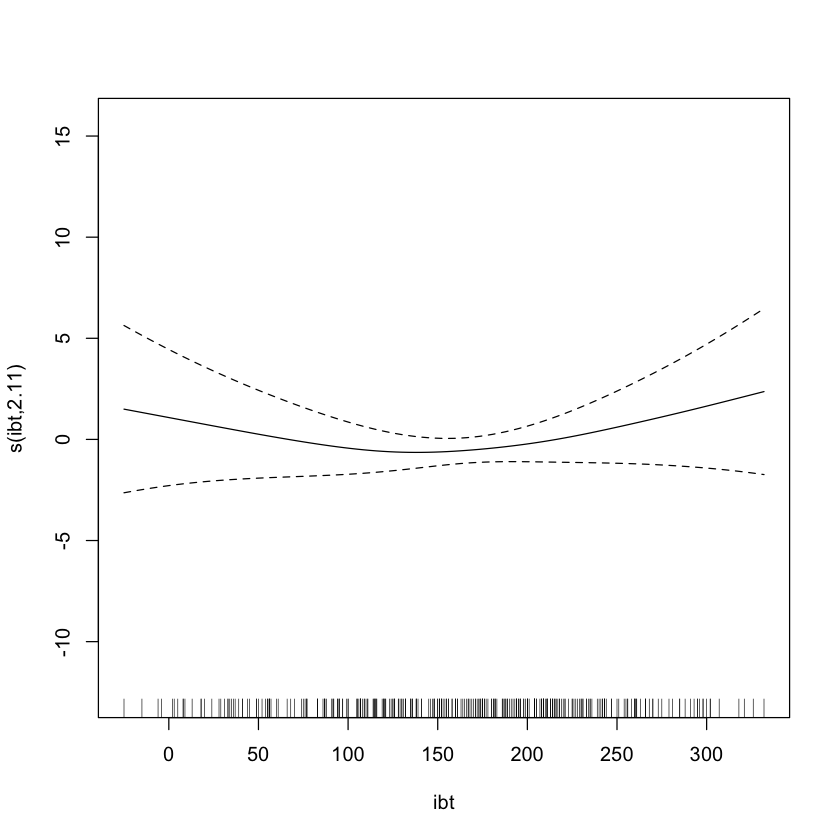

In [34]:
plot(gammod)

In [35]:
am1 = gam(O3 ~ s(temp) + s(ibh), data = ozone)
am2 = gam(O3 ~ temp + s(ibh), data = ozone)
anova(am2, am1, test = "F")

Resid. Df,Resid. Dev,Df,Deviance,F,Pr(>F)
322.7383,6949.966,NA,NA,NA,NA
319.1147,6053.991,3.623656,895.9755,13.10894,3.146492e-09
